In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-08-01 14:24:51.630192: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-01 14:24:53.911568: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 14:24:56.358469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)

def datacleaning_amazon():
    dataset = load_dataset("amazon_us_reviews", "Apparel_v1_00")
    train_data = dataset['train']

    train_data = train_data.select(range(50000))

    # Filter rows with review_body length less than or equal to 256 words
    train_data = train_data.filter(lambda example: count_words(example['review_body']) <= 256)

    # Limit the dataset to the first 10,000 rows
    train_data = train_data.select(range(10000))

    df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame
    df = df[['customer_id', 'review_headline', 'review_body', 'star_rating']]  # Select specific columns
    df.columns = ['customer_id', 'review_headline', 'review_body', 'star_rating']  # Rename the selected columns
    df.set_index('customer_id', inplace=True)

    df['sentiment'] = df['star_rating'].map({5: 'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'})

    possible_labels = df.sentiment.unique()  # Get unique category labels from the DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.sentiment.replace(label_dict)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set'] * df.shape[0]  # Set a new column 'data_type' for later data split

    # Set the 'data_type' column of the dataframe for training and validation data
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels, label_dict):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Initialize the confusion matrix.
    num_classes = len(label_dict)
    confusion_mat = confusion_matrix(labels_flat, preds_flat, labels=list(range(num_classes)))
    
    # Calculate accuracy and F1 score per class
    accuracies = {}
    f1_scores = {}
    for label in range(num_classes):
        # Calculate accuracy for this class
        num_correct = confusion_mat[label, label]
        num_instances = np.sum(confusion_mat[label, :])
        accuracy = num_correct / num_instances * 100
        accuracies[label] = accuracy
        
        # Calculate F1 score for this class
        f1 = f1_score(labels_flat, preds_flat, labels=[label], average='weighted')
        f1_scores[label] = f1

        # Print the class name, accuracy numerator, and denominator.
        class_name = label_dict_inverse[label]
        print(f'Class: {class_name}')
        print(f'Accuracy: {num_correct}/{num_instances} ({accuracy:.2f}%)')
        print(f'F1 Score: {f1:.2f}\n')

    # Calculate total accuracy and F1 score
    total_accuracy = accuracy_score(labels_flat, preds_flat) * 100
    total_f1_score = f1_score(labels_flat, preds_flat, average='weighted')

    # Print the total accuracy and F1 score
    print(f'Total Accuracy: {total_accuracy:.2f}%')
    print(f'Total F1 Score: {total_f1_score:.2f}')


#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_textcnn_amazon_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

    return training_loss_list, validation_loss_list, accuracy_list, precision_list, f1_score_list

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = datacleaning_amazon()

Found cached dataset amazon_us_reviews (/home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563/cache-39524de3311549b5.arrow


In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,review_headline,review_body,star_rating,sentiment,label,data_type
customer_id,,,,,,
50867430,Absolutely must,Fits great! Feels comfortable! An overall grea...,5,good,0,train
14094716,Five Stars,Item is ok,5,good,0,val
36322626,Two Stars,This shirt runs extremely small. I generally ...,2,bad,2,train
16521558,Five Stars,Love it,5,good,0,train
28567406,Five Stars,Great for computer backups.,5,good,0,train
28796755,Five Stars,"Great fit, very comfortable!",5,good,0,train
159429,Runs Very Small,The product looks like the picture and the fab...,4,good,0,train
117231,Five Stars,"I luv it,",5,good,0,train
1965478,Ugh.,"I bought this design and one other, both XXL, ...",1,bad,2,val


[nltk_data] Downloading package punkt to /home/z123010/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


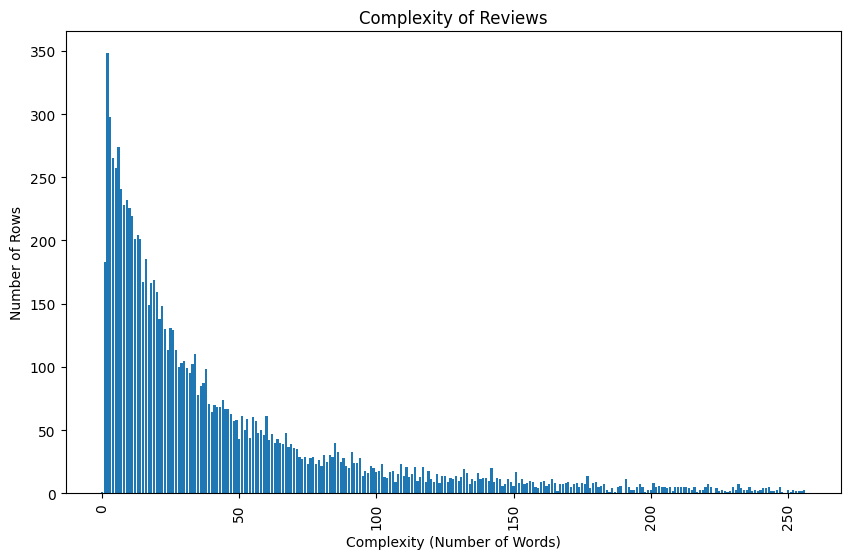

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

# Download the punkt tokenizer (if not already downloaded)
nltk.download('punkt')

# Function to count the number of words in a given text
def count_words(text):
    words = word_tokenize(text)
    return len(words)

# Apply the count_words function to each row of the review_body column
df['word_count'] = df['review_body'].apply(count_words)

# Group by the word_count and count how many rows have reviews of that length
word_count_df = df['word_count'].value_counts().reset_index()
word_count_df.columns = ['Complexity (Number of Words)', 'Number of Rows']

# Sort the DataFrame by the complexity (number of words) in ascending order
word_count_df.sort_values(by='Complexity (Number of Words)', inplace=True)

# Create a bar plot to visualize the complexity and the number of rows
plt.figure(figsize=(10, 6))
plt.bar(word_count_df['Complexity (Number of Words)'], word_count_df['Number of Rows'])
plt.xlabel('Complexity (Number of Words)')
plt.ylabel('Number of Rows')
plt.title('Complexity of Reviews')
plt.xticks(rotation=90)
plt.show()


In [7]:
df.groupby(['star_rating', 'label', 'data_type']).count()

review_headline  review_body  sentiment   
star_rating label data_type                                            
1           2     train                  907          907        907  \
                  val                    190          190        190   
2           2     train                  490          490        490   
                  val                     83           83         83   
3           1     train                  683          683        683   
                  val                    135          135        135   
4           0     train                 1330         1330       1330   
                  val                    261          261        261   
5           0     train                 4665         4665       4665   
                  val                   1256         1256       1256   

                             word_count  
star_rating label data_type              
1           2     train             907  
                  val               190  
2           2     train             490  
                  val                83  
3           1     train             683  
                  val               135  
4           0     train            1330  
                  val               261  
5           0     train            4665  
                  val              1256

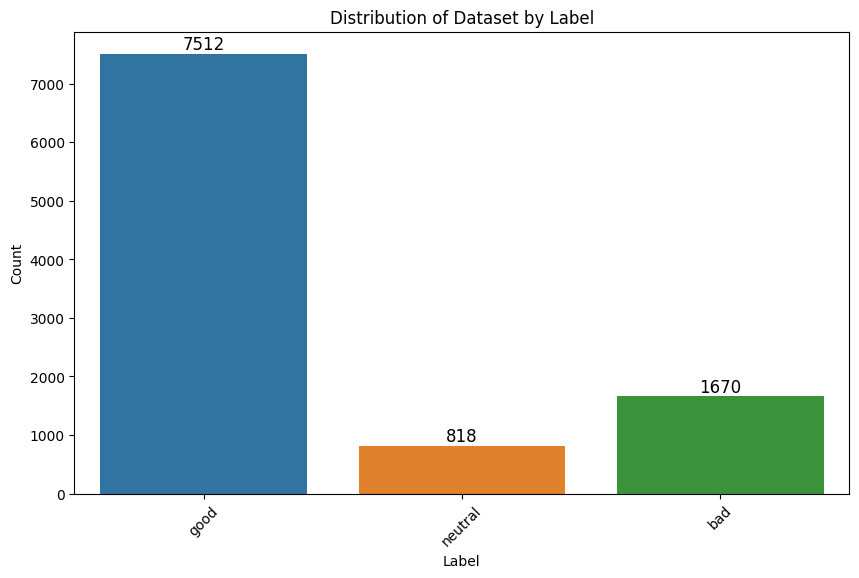

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the data already grouped as mentioned in your initial code
grouped_data = df.groupby(['label']).count()

# Reset the index to access the 'label' and 'data_type' columns
grouped_data.reset_index(inplace=True)

# Map numeric labels to text labels
label_mapping = {0: 'good', 1: 'neutral', 2: 'bad'}
grouped_data['label'] = grouped_data['label'].map(label_mapping)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='data_type', data=grouped_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Dataset by Label')

# Add count numbers as annotations to each bar
for index, row in grouped_data.iterrows():
    count = row['data_type']
    plt.text(index, count, str(count), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)
plt.show()


In [9]:
# Load BERT tokenizer
pretrained_path = 'gpt2'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_train_body = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train_headline = encoded_data_train_headline['input_ids']
attention_masks_train_headline = encoded_data_train_headline['attention_mask']

input_ids_train_body = encoded_data_train_body['input_ids']
attention_masks_train_body = encoded_data_train_body['attention_mask']

input_ids_train = torch.cat((input_ids_train_headline, input_ids_train_body), dim=1)
attention_masks_train = torch.cat((attention_masks_train_headline, attention_masks_train_body), dim=1)

labels_train = torch.tensor(df[df.data_type=='train'].label.values)


encoded_data_val_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val_body = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val_headline = encoded_data_val_headline['input_ids']
attention_masks_val_headline = encoded_data_val_headline['attention_mask']

input_ids_val_body = encoded_data_val_body['input_ids']
attention_masks_val_body = encoded_data_val_body['attention_mask']

input_ids_val = torch.cat((input_ids_val_headline, input_ids_val_body), dim=1)
attention_masks_val = torch.cat((attention_masks_val_headline, attention_masks_val_body), dim=1)

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [10]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(8075, 1925)

In [11]:
from transformers import GPT2Model, GPT2Config

num_classes = 3

class SentimentModel(nn.Module):
    def __init__(self, pretrained_path, num_classes, cnn_out_channels, cnn_kernel_sizes):
        super(SentimentModel, self).__init__()

        gpt_config = GPT2Config.from_pretrained(            
            pretrained_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3)
        self.gpt = GPT2Model.from_pretrained(pretrained_path, config=gpt_config)
        
        self.dropout = nn.Dropout(0.2)
        self.convs = nn.ModuleList([
            nn.Conv1d(1, cnn_out_channels, kernel_size) for kernel_size in cnn_kernel_sizes
        ])
        self.fc = nn.Linear(cnn_out_channels * len(cnn_kernel_sizes), num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        
        output = torch.cat((gpt_last_hidden_state,), dim=1)
    
        # Add an extra dimension to pooled_output
        output = output.unsqueeze(2)
    
        # Permute the dimensions of pooled_output
        output = output.permute(0, 2, 1)
    
        # Remove the extra dimension from pooled_output
        output = output.squeeze(2)
    
        # Apply convolution operation for each kernel size
        conv_outputs = [conv(output) for conv in self.convs]
    
        # Apply max pooling over each convolution output
        max_pooled = [torch.max(conv_output, dim=2)[0] for conv_output in conv_outputs]
    
        # Concatenate max pooled features from different kernel sizes
        concatenated = torch.cat(max_pooled, dim=1)
    
        logits = self.fc(concatenated)
        outputs = nn.functional.softmax(logits, dim=1)
    
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs



In [12]:
pretrained_path = "gpt2"
gpt_config = GPT2Config.from_pretrained(pretrained_path)
cnn_out_channels = 256
cnn_kernel_sizes = [2, 3, 4, 5]

model = SentimentModel(pretrained_path, num_classes, cnn_out_channels, cnn_kernel_sizes)

In [13]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (convs): ModuleList(
    (0): Conv1d(1, 256, kernel_size=(2,), stride=(1,))
    (1): Conv1d(1, 256, kernel_size=(3,), stride=(1,))
    (2): Conv1d(

In [14]:
# Count total params, trainable params, and non-trainable params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

# Print the results
print(f"Total Params: {total_params}")
print(f"Trainable Params: {trainable_params}")
print(f"Non-trainable Params: {non_trainable_params}")

Total Params: 124447491
Trainable Params: 124447491
Non-trainable Params: 0


In [15]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Define the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8,
    weight_decay=0.01

)


epochs = 10
patience = 3
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda



Fold 1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7318781226052727
Validation loss: 0.6227465688739673
F1 Score (weighted): 0.7587831957920426


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5023450409995834
Validation loss: 0.498443616236016
F1 Score (weighted): 0.8376388437520477
31.36% Training loss decreased compared to the previous epoch
19.96% Validation loss decreased compared to the previous epoch
10.39% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.42174083234495624
Validation loss: 0.42263662496507903
F1 Score (weighted): 0.839458995629826
16.05% Training loss decreased compared to the previous epoch
15.21% Validation loss decreased compared to the previous epoch
0.22% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.38341680068654094
Validation loss: 0.47147394724519887
F1 Score (weighted): 0.8519761323274155
9.09% Training loss decreased compared to the previous epoch
11.56% Validation loss increased compared to the previous epoch
1.49% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3630245763753451
Validation loss: 0.44927431047562105
F1 Score (weighted): 0.8525551827112838
5.32% Training loss decreased compared to the previous epoch
4.71% Validation loss decreased compared to the previous epoch
0.07% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.3502329682346814
Validation loss: 0.5142624544012614
F1 Score (weighted): 0.8536268910607591
3.52% Training loss decreased compared to the previous epoch
14.47% Validation loss increased compared to the previous epoch
0.13% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 25.387931648890177 minutes
Final Accuracy: 0.871826625386997
Final Precision: 0.8754119421511534


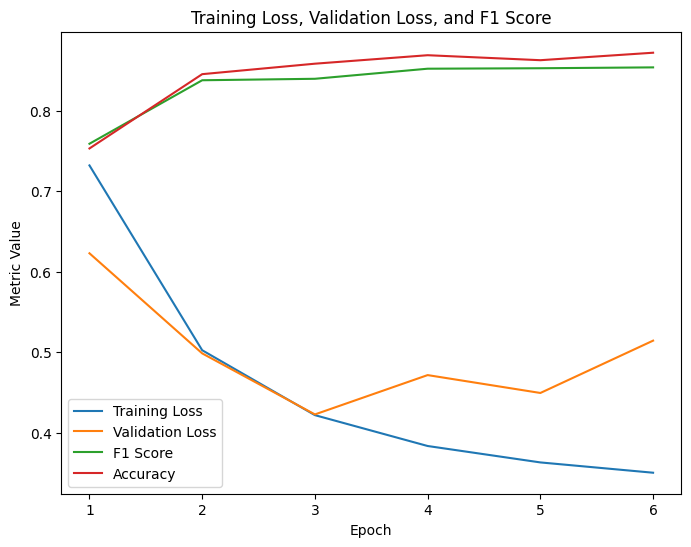

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.7318781226052727   0.6227465688739673   0.7587831957920426  0.7529411764705882     0.842646
2                     0.5023450409995834   0.498443616236016    0.8376388437520477  0.8376388437520477     0.837639
3                     0.42174083234495624  0.42263662496507903  0.839458995629826   0.839458995629826      0.839459
4                     0.38341680068654094  0.47147394724519887  0.8519761323274155  0.8519761323274155     0.851976
5                     0.3630245763753451   0.44927431047562105  0.8525551827112838  0.8525551827112838     0.852555
6                     0.3502329682346814   0.5142624544012614   0.8536268910607591  0.8536268910607591     0.853627
Total Training Time                                                     

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.37397581557737486
Validation loss: 0.24789578921742517
F1 Score (weighted): 0.8898425028416428


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3561291192076133
Validation loss: 0.29142237612908467
F1 Score (weighted): 0.894739625504794
4.77% Training loss decreased compared to the previous epoch
17.56% Validation loss increased compared to the previous epoch
0.55% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.34015943415728866
Validation loss: 0.29391958733941637
F1 Score (weighted): 0.8919564280517362
4.48% Training loss decreased compared to the previous epoch
0.86% Validation loss increased compared to the previous epoch
0.31% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.34509461346989145
Validation loss: 0.3468819765431984
F1 Score (weighted): 0.884461515949287
1.45% Training loss increased compared to the previous epoch
18.02% Validation loss increased compared to the previous epoch
0.84% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 16.824465179443358 minutes
Final Accuracy: 0.8959752321981425
Final Precision: 0.9151678747860339


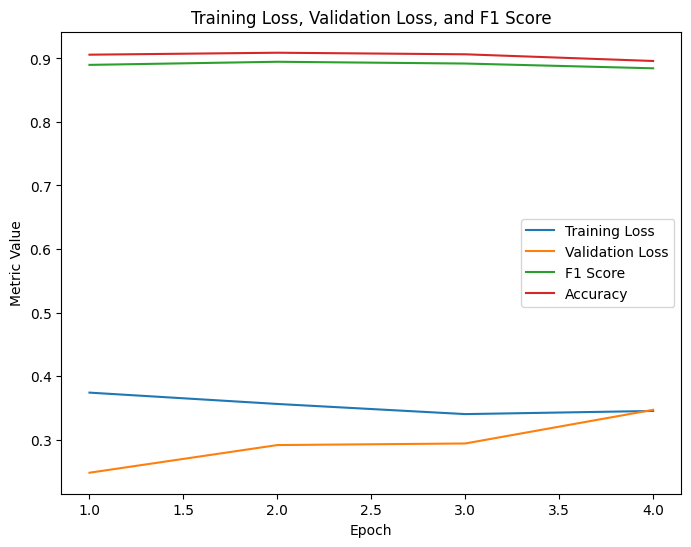

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.37397581557737486  0.24789578921742517  0.8898425028416428  0.9058823529411765     0.910032
2                     0.3561291192076133   0.29142237612908467  0.894739625504794   0.894739625504794      0.89474
3                     0.34015943415728866  0.29391958733941637  0.8919564280517362  0.8919564280517362     0.891956
4                     0.34509461346989145  0.3468819765431984   0.884461515949287   0.884461515949287      0.884462
Total Training Time                                                                                     1009.47
Final Precision                                                                                            0.915168
Total Time (minutes)                                                         

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3388758365253134
Validation loss: 0.19287661577413254
F1 Score (weighted): 0.9174143419784238


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.35078323777405346
Validation loss: 0.18791448855995216
F1 Score (weighted): 0.9135880425678267
3.51% Training loss increased compared to the previous epoch
2.57% Validation loss decreased compared to the previous epoch
0.42% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3105511644959355
Validation loss: 0.1816787118852949
F1 Score (weighted): 0.9172606569274789
11.47% Training loss decreased compared to the previous epoch
3.32% Validation loss decreased compared to the previous epoch
0.4% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.32782068840560447
Validation loss: 0.1816795351108943
F1 Score (weighted): 0.9172606569274789
5.56% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.31266608883988106
Validation loss: 0.18169237593535245
F1 Score (weighted): 0.9172606569274789
4.62% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.3096422974421947
Validation loss: 0.1816953099818294
F1 Score (weighted): 0.9172606569274789
0.97% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 25.24760283231735 minutes
Final Accuracy: 0.9325077399380804
Final Precision: 0.9386923302381159


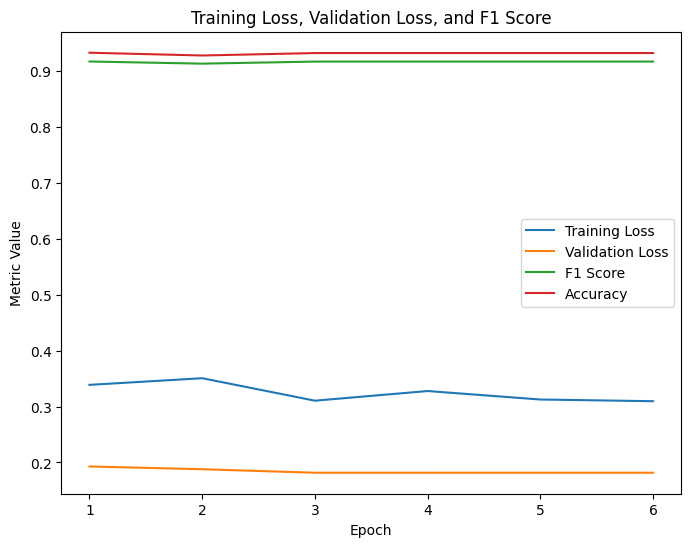

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.3388758365253134   0.19287661577413254  0.9174143419784238  0.9331269349845202     0.93769
2                     0.35078323777405346  0.18791448855995216  0.9135880425678267  0.9135880425678267     0.913588
3                     0.3105511644959355   0.1816787118852949   0.9172606569274789  0.9172606569274789     0.917261
4                     0.32782068840560447  0.1816795351108943   0.9172606569274789  0.9172606569274789     0.917261
5                     0.31266608883988106  0.18169237593535245  0.9172606569274789  0.9172606569274789     0.917261
6                     0.3096422974421947   0.1816953099818294   0.9172606569274789  0.9172606569274789     0.917261
Total Training Time                                                      

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3095460399848043
Validation loss: 0.21703575944454792
F1 Score (weighted): 0.9093767994516532


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3057462158418581
Validation loss: 0.21714603482793998
F1 Score (weighted): 0.9093767994516532
1.23% Training loss decreased compared to the previous epoch
0.05% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.30555764436985444
Validation loss: 0.21715218501128336
F1 Score (weighted): 0.9093767994516532
0.06% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.29477164774997805
Validation loss: 0.2170300158282447
F1 Score (weighted): 0.9093767994516532
3.53% Training loss decreased compared to the previous epoch
0.06% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3082872968649225
Validation loss: 0.217044760165033
F1 Score (weighted): 0.9093767994516532
4.59% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.30603578047355157
Validation loss: 0.21722340425280845
F1 Score (weighted): 0.9093767994516532
0.73% Training loss decreased compared to the previous epoch
0.08% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.3083675953457534
Validation loss: 0.21733675684591428
F1 Score (weighted): 0.9093767994516532
0.76% Training loss increased compared to the previous epoch
0.05% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 29.46183734337489 minutes
Final Accuracy: 0.9256965944272446
Final Precision: 0.9303705651819152


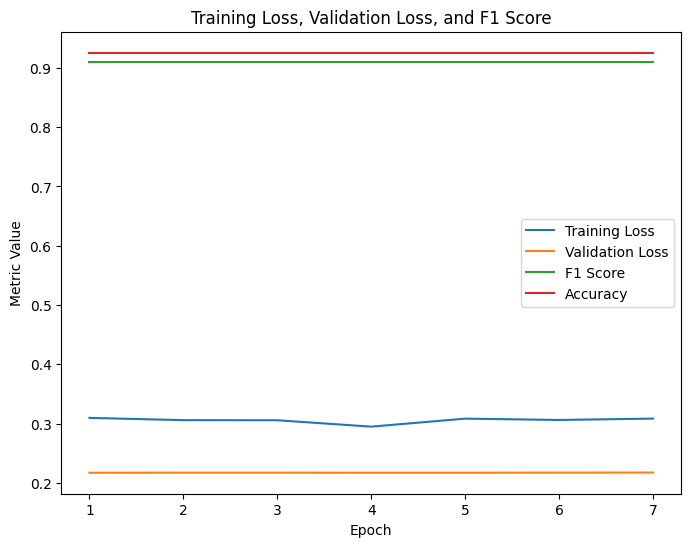

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.3095460399848043   0.21703575944454792  0.9093767994516532  0.9256965944272446     0.930371
2                     0.3057462158418581   0.21714603482793998  0.9093767994516532  0.9093767994516532     0.909377
3                     0.30555764436985444  0.21715218501128336  0.9093767994516532  0.9093767994516532     0.909377
4                     0.29477164774997805  0.2170300158282447   0.9093767994516532  0.9093767994516532     0.909377
5                     0.3082872968649225   0.217044760165033    0.9093767994516532  0.9093767994516532     0.909377
6                     0.30603578047355157  0.21722340425280845  0.9093767994516532  0.9093767994516532     0.909377
7                     0.3083675953457534   0.21733675684591428  0.909376

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.30476017519250304
Validation loss: 0.24143322205205855
F1 Score (weighted): 0.9039596394778812


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3011125650804442
Validation loss: 0.24132014224078105
F1 Score (weighted): 0.9039596394778812
1.2% Training loss decreased compared to the previous epoch
0.05% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.29901418523735684
Validation loss: 0.24299674329799162
F1 Score (weighted): 0.9039596394778812
0.7% Training loss decreased compared to the previous epoch
0.69% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2992913310767162
Validation loss: 0.2413066681058061
F1 Score (weighted): 0.9039596394778812
0.09% Training loss increased compared to the previous epoch
0.7% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.30609413837584437
Validation loss: 0.24148653155249789
F1 Score (weighted): 0.9039596394778812
2.27% Training loss increased compared to the previous epoch
0.07% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.29742618299732754
Validation loss: 0.24158302085781164
F1 Score (weighted): 0.9039596394778812
2.83% Training loss decreased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.29801775477171577
Validation loss: 0.2419320451113566
F1 Score (weighted): 0.9039596394778812
0.2% Training loss increased compared to the previous epoch
0.14% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 29.44792505900065 minutes
Final Accuracy: 0.9207430340557275
Final Precision: 0.9272621972919588


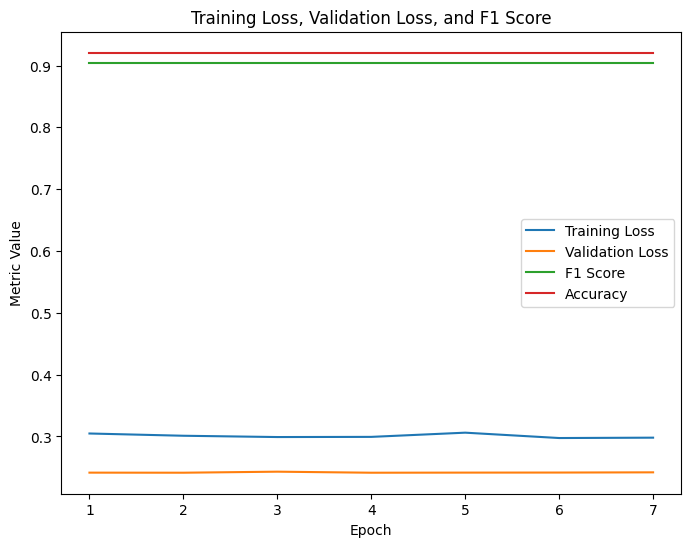

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.30476017519250304  0.24143322205205855  0.9039596394778812  0.9207430340557275     0.927262
2                     0.3011125650804442   0.24132014224078105  0.9039596394778812  0.9039596394778812     0.90396
3                     0.29901418523735684  0.24299674329799162  0.9039596394778812  0.9039596394778812     0.90396
4                     0.2992913310767162   0.2413066681058061   0.9039596394778812  0.9039596394778812     0.90396
5                     0.30609413837584437  0.24148653155249789  0.9039596394778812  0.9039596394778812     0.90396
6                     0.29742618299732754  0.24158302085781164  0.9039596394778812  0.9039596394778812     0.90396
7                     0.29801775477171577  0.2419320451113566   0.90395963947

In [21]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_vals = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # Initialize metrics lists for this fold
    fold_training_loss_list = []
    fold_validation_loss_list = []
    fold_accuracy_list = []
    fold_precision_list = []
    fold_f1_score_list = []

    try:
        fold_training_loss_list, fold_validation_loss_list, fold_accuracy_list, fold_precision_list, fold_f1_score_list = \
        train_model(trainer, dataloader_train, dataloader_vals, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3011704964783348
Validation loss: 0.35688260733306937
F1 Score (weighted): 0.8876967283101959


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2917010580862426
Validation loss: 0.35702374740091625
F1 Score (weighted): 0.8876967283101959
3.14% Training loss decreased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3022615737165216
Validation loss: 0.3590965493503935
F1 Score (weighted): 0.8876967283101959
3.62% Training loss increased compared to the previous epoch
0.58% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.3039408751421325
Validation loss: 0.3580619614926134
F1 Score (weighted): 0.8876967283101959
0.56% Training loss increased compared to the previous epoch
0.29% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 16.826512972513836 minutes
Final Accuracy: 0.9023376623376623
Final Precision: 0.9074702229139885


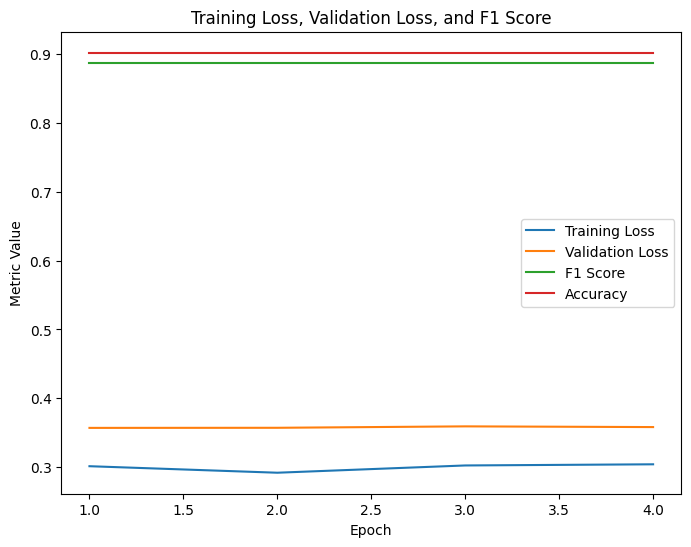

Epoch                 Training Loss       Validation Loss      F1 Score            Accuracy              Precision
--------------------  ------------------  -------------------  ------------------  ------------------  -----------
1                     0.3011704964783348  0.35688260733306937  0.8876967283101959  0.9023376623376623     0.90747
2                     0.2917010580862426  0.35702374740091625  0.8876967283101959  0.8876967283101959     0.887697
3                     0.3022615737165216  0.3590965493503935   0.8876967283101959  0.8876967283101959     0.887697
4                     0.3039408751421325  0.3580619614926134   0.8876967283101959  0.8876967283101959     0.887697
Total Training Time                                                                                    1009.59
Final Precision                                                                                           0.90747
Total Time (minutes)                                                                  

([0.3011704964783348,
  0.2917010580862426,
  0.3022615737165216,
  0.3039408751421325],
 [0.35688260733306937,
  0.35702374740091625,
  0.3590965493503935,
  0.3580619614926134],
 [0.9023376623376623,
  0.9023376623376623,
  0.9023376623376623,
  0.9023376623376623],
 [0.9074702229139885,
  0.9074702229139885,
  0.9074702229139885,
  0.9074702229139885],
 [0.8876967283101959,
  0.8876967283101959,
  0.8876967283101959,
  0.8876967283101959])

In [22]:
train_model(trainer, dataloader_train, dataloader_val, epochs, patience)